# Google Stock Price Prediction using LSTM - Part 3

### **Notebook #3: Model Development, Experimentation, and Forecasting**

In this notebook, we aim to build and optimize a model for stock price forecasting. This phase focuses on developing a robust and accurate prediction model by experimenting with different architectures and hyperparameters, evaluating performance, and generating prediction.


#### **Outcome of This Notebook**:
By the end of this notebook, we aim to:
- Develop a well-tuned LSTM model capable of accurately predicting stock prices.
- Evaluate the model's performance using quantitative metrics and visual analysis.
- Generate stock price prediction 

## 1. Libraries & Environment Setup

In [1]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import joblib


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras_tuner import RandomSearch

# Set random seeds for reproducibility
random.seed(42)          # Set Python's random seed
np.random.seed(42)       # Set NumPy's random seed
tf.random.set_seed(42)   # Set TensorFlow's random seed

# Configure TensorFlow for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))



2024-12-03 12:46:34.044942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
[]


## 2. Data Loading

In [2]:
# Load training, validation, and test data
#train_data = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/processed/train_data_split.csv')
#validation_data = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/processed/validation_data_split.csv')
#test_data = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/interim/test_data_cleaned.csv')

train_data_scaled = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/processed/scaled_train_data.csv')
validation_data_scaled = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/processed/scaled_validation_data.csv')
test_data_scaled = pd.read_csv('/Users/aries/Downloads/StockPrediction/data/processed/scaled_test_data.csv')


In [3]:
# Print the shape of the training and validation data
print("Training Data Shape:", train_data_scaled.shape)
print("Validation Data Shape:", validation_data_scaled.shape)
print("Testing Data Shape:", test_data_scaled.shape)

Training Data Shape: (571, 6)
Validation Data Shape: (127, 6)
Testing Data Shape: (20, 6)


In [4]:
train_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    571 non-null    object 
 1   Open    571 non-null    float64
 2   High    571 non-null    float64
 3   Low     571 non-null    float64
 4   Close   571 non-null    float64
 5   Volume  571 non-null    float64
dtypes: float64(5), object(1)
memory usage: 26.9+ KB


In [5]:
validation_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    127 non-null    object 
 1   Open    127 non-null    float64
 2   High    127 non-null    float64
 3   Low     127 non-null    float64
 4   Close   127 non-null    float64
 5   Volume  127 non-null    float64
dtypes: float64(5), object(1)
memory usage: 6.1+ KB


In [6]:
test_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.1+ KB


## 3. Constructing Data for LSTM Model

LSTMs require a 3D input because they process data sequentially across timesteps, and the third dimension accommodates multiple features per timestep. Even if you have only one feature (e.g., closing price), the LSTM still expects this dimension to be explicitly specified. This reshaping step ensures the data is compatible with the LSTM model's input expectations.

In [7]:
# Ensure the Date column is in datetime format and extract dates and features
def extract_date_and_features(data):
    """
    Ensures the 'Date' column is in datetime format, 
    then separates date and features from a dataset.

    Parameters:
    - data (pd.DataFrame): The dataset containing 'Date' and other columns.

    Returns:
    - dates (pd.Series): The 'Date' column in datetime format.
    - features (pd.DataFrame): The numerical features excluding 'Date'.
    """
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert Date to datetime format
    dates = data['Date']  # Extract the Date column
    features = data.drop(columns=['Date'])  # Drop the Date column for numerical features
    return dates, features

In [8]:
# Apply the function to train, validation, and test datasets
train_dates, train_features = extract_date_and_features(train_data_scaled)
val_dates, val_features = extract_date_and_features(validation_data_scaled)
test_dates, test_features = extract_date_and_features(test_data_scaled)

# Verify the extracted data
print("Train Dates:", train_dates.shape, "Features:", train_features.shape)
print("Validation Dates:", val_dates.shape, "Features:", val_features.shape)
print("Test Dates:", test_dates.shape, "Features:", test_features.shape)

# Display a sample of the extracted dates to confirm proper format
print("\nSample Dates from Train Data:")
print(train_dates.head())


Train Dates: (571,) Features: (571, 5)
Validation Dates: (127,) Features: (127, 5)
Test Dates: (20,) Features: (20, 5)

Sample Dates from Train Data:
0   2014-03-27
1   2014-03-28
2   2014-03-31
3   2014-04-01
4   2014-04-02
Name: Date, dtype: datetime64[ns]


In [9]:
def construct_lstm_input(data, sequence_length, target_column):
    """
    Constructs LSTM input sequences (X) and corresponding targets (y) from a pandas DataFrame.

    Parameters:
    -----------
    data : pandas.DataFrame
        The DataFrame containing the features and the target column to predict.

    sequence_length : int
        The number of previous time steps to use as input features for each prediction.

    target_column : str
        The name of the column to be predicted (target variable).

    Returns:
    --------
    X : numpy.ndarray
        3D array of LSTM input sequences with shape (n_samples, sequence_length, n_features).

    y : numpy.ndarray
        1D array of target values with shape (n_samples,).
    """
    X, y = [], []  # Initialize lists to store input sequences and target values
    
    # Convert the DataFrame to a NumPy array for efficient slicing
    data_array = data.values  # Converts the DataFrame to a NumPy array for faster array manipulation

    # Get the column index of the target variable from the DataFrame
    target_index = data.columns.get_loc(target_column)  # Finds the index of the target column

    # Loop through the dataset to create sliding windows of input sequences and corresponding targets
    for i in range(len(data) - sequence_length):
        # Extract a sequence of features for the current window
        X.append(data_array[i:i + sequence_length, :])  # Collect `sequence_length` rows of features
        
        # Extract the target value corresponding to the next time step
        y.append(data_array[i + sequence_length, target_index])  # Target is the value after the sequence
    
    # Convert the collected input sequences (X) and targets (y) to NumPy arrays
    X = np.array(X)  # Convert list of input sequences to a 3D NumPy array
    y = np.array(y)  # Convert list of targets to a 1D NumPy array
    
    return X, y  # Return the LSTM-ready input and target arrays


In [10]:
# Calculate data size for each period
train_data_length = len(train_features)
validation_data_length = len(val_features)
test_data_length = len(test_features)

# Combine scaled datasets all together
full_scaled_data = pd.concat([train_features, val_features, test_features], axis=0)

sequence_length = 60  # Example: Use the past 100 days for prediction
target = 'Close'

# Construct the input sequences and corresponding targets for the training data
X_train, y_train = construct_lstm_input(train_features, sequence_length, target)

# Construct the input sequences and corresponding targets for the validation data
X_val, y_val = construct_lstm_input(
    full_scaled_data.iloc[train_data_length - sequence_length:train_data_length + validation_data_length, :], 
    sequence_length, 
    target_column='Close'  # Assuming 'Close' is the target column name
)

# Construct the input sequences and corresponding targets for the test data
X_test, y_test = construct_lstm_input(
    full_scaled_data.iloc[-(test_data_length + sequence_length):, :], 
    sequence_length, 
    target_column='Close'  # Assuming 'Close' is the target column name
)

In [11]:
# Print shapes for training, validation, and test data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (511, 60, 5)
y_train shape: (511,)
X_val shape: (127, 60, 5)
y_val shape: (127,)
X_test shape: (20, 60, 5)
y_test shape: (20,)


## 4. Model Training

The **Model Training Section** is structured to provide a systematic and modularized approach for developing, training, and evaluating an LSTM model for stock price predictions. Below is an overview of the key steps involved in this process:


1. **Model Creation (`create_lstm_model`)**  
   - This function defines the architecture of the LSTM model. It accepts an `input_shape` and a configuration dictionary (`lstm_config`) to customize the number of LSTM and dense layers, their respective units, and other attributes such as dropout rates and activation functions. 
   - It also allows customization of the optimizer (`adam` by default) and its learning rate.
   - The resulting model is compiled with a mean squared error (MSE) loss function and the specified optimizer, ensuring flexibility for various training scenarios.



2. **Loss Visualization (`plot_loss`)**  
   - This function generates a visual representation of the training and validation losses over epochs. By plotting these values, it becomes easier to identify underfitting, overfitting, or optimal convergence of the model during training.



3. **Model Evaluation (`evaluate_model`)**  
   - After training, the model's performance is evaluated on the training, validation, and test datasets.  
   - RMSE (Root Mean Squared Error) is calculated for each dataset to provide a quantitative measure of the model's predictive accuracy across different data splits.



4. **Prediction Restoration (`restore_predictions`)**  
   - Since the target data is scaled during preprocessing, this function restores the original scale of the predicted values. It ensures the predictions are comparable with the actual stock prices by using the same scaler applied during data normalization.



5. **Full Prediction Visualization (`plot_stock_predictions`)**  
   - This function generates comprehensive plots of actual vs. predicted stock prices for the training, validation, and test datasets.  
   - It visually assesses how well the model tracks stock price trends across the different data splits, ensuring the consistency of predictions over time.



6. **Recent Predictions Analysis (`plot_recent_predictions`)**  
   - To focus on recent trends, this function zooms into the last few samples (default is 30) from the validation and test datasets.  
   - It highlights the model's short-term prediction capabilities, which is particularly important for applications requiring up-to-date forecasting.



### Model Creation Function

In [12]:
def create_lstm_model(input_shape, lstm_config, optimizer_name='adam', learning_rate=0.01):
    """
    Creates an LSTM model based on the provided configuration.

    Parameters:
    -----------
    input_shape : tuple
        The shape of the input data (timesteps, features).
    
    lstm_config : dict
        Configuration for the LSTM layers and dense layers. 
        Example structure:
        {
            'lstm_layers': [
                {'units': 50, 'return_sequences': True, 'dropout_rate': 0.2},
                {'units': 30, 'return_sequences': False}
            ],
            'dense_layers': [
                {'units': 10, 'activation': 'relu'},
                {'units': 1, 'activation': 'linear'}
            ]
        }

    optimizer_name : str, optional (default='adam')
        The name of the optimizer to use ('adam' or 'rmsprop').

    learning_rate : float, optional (default=0.01)
        The learning rate for the optimizer.

    Returns:
    --------
    model : keras.Sequential
        The compiled LSTM model ready for training.
    """
    model = Sequential()  # Initialize a Sequential model

    # Add the input layer
    model.add(Input(shape=input_shape))  # Define the input shape for the model

    # Add LSTM layers based on the provided configuration
    for i, layer in enumerate(lstm_config['lstm_layers']):
        model.add(LSTM(
            units=layer['units'],  # Number of units in the LSTM layer
            return_sequences=layer.get('return_sequences', False)  # Whether to return sequences for the next layer
        ))
        if layer.get('dropout_rate'):  # Add a Dropout layer if specified in the configuration
            model.add(Dropout(layer['dropout_rate']))

    # Add Dense (fully connected) layers based on configuration
    for layer in lstm_config['dense_layers']:
        model.add(Dense(
            units=layer['units'],  # Number of neurons in the dense layer
            activation=layer.get('activation', 'linear')  # Activation function (default is 'linear')
        ))

    # Define and configure the optimizer
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate)
    }.get(optimizer_name, Adam(learning_rate=learning_rate))  # Use 'adam' as default if optimizer_name is invalid

    # Compile the model with the specified optimizer and mean squared error loss
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


def train_with_experiment(model, X_train, y_train, X_val, y_val, experiment_name, epochs=50, batch_size=32):
    """
    Train the model and save the best one based on validation loss using checkpoints.

    Parameters:
    -----------
    model : keras.Model
        The compiled LSTM model to be trained.
    
    X_train, y_train : numpy.ndarray
        Training data and corresponding target values.

    X_val, y_val : numpy.ndarray
        Validation data and corresponding target values.

    experiment_name : str
        Name or identifier for the experiment (used in saving the best model).

    epochs : int, optional (default=50)
        Number of epochs to train the model.

    batch_size : int, optional (default=32)
        Size of each batch during training.

    Returns:
    --------
    history : keras.callbacks.History
        The training history, which includes loss and validation loss per epoch.
    """
    # Define the file path and name for saving the best model
    model_location = "/Users/aries/Downloads/StockPrediction/models/"  # Ensure this path exists
    model_name = f"{experiment_name}.model.keras"  # Model name based on the experiment name

    # Set up a checkpoint callback to save the best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        os.path.join(model_location, model_name),  # Full path to save the model
        monitor="val_loss",  # Monitor the validation loss
        save_best_only=True,  # Save only the best model (lowest validation loss)
        mode="min",  # Look for the minimum validation loss
        verbose=1  # Print progress during training
    )

    # Train the model and use the checkpoint callback
    history = model.fit(
        X_train, y_train,  # Training data and labels
        epochs=epochs,  # Number of epochs
        batch_size=batch_size,  # Batch size for training
        validation_data=(X_val, y_val),  # Validation data
        verbose=1,  # Print training progress
        callbacks=[checkpoint_callback]  # Include the checkpoint callback
    )

    return history  # Return the training history


### Loss Visualization

In [13]:
def plot_loss(history):
    """
    Plots the training and validation loss (Mean Squared Error - MSE) from the model's training history.

    Parameters:
    -----------
    history : keras.callbacks.History
        The history object returned by the `model.fit()` function. It contains the loss and validation loss values
        recorded at each epoch during training.

    Returns:
    --------
    None
        Displays a plot showing the training and validation loss over epochs.
    """
    plt.figure(figsize=(18, 6))  # Set the figure size for the plot

    # Plot the Training and Validation Loss (MSE) on the first subplot
    plt.subplot(1, 2, 1)  # Create a subplot in a 1x2 grid (1 row, 2 columns), select the first plot
    plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='red')  # Plot validation loss
    plt.title('Training and Validation Loss (MSE)')  # Set the title of the plot
    plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
    plt.ylabel('Loss (MSE)')  # Label the y-axis as 'Loss (MSE)'
    plt.legend()  # Add a legend to differentiate between training and validation loss

    # Adjust the layout to prevent overlapping elements
    plt.tight_layout()

    # Display the plot
    plt.show()


### Model Evaluation

In [14]:
def restore_predictions(predictions, true_values, scaler, num_features=5):
    """
    Restore the original scale of the predicted values.
    
    Parameters:
    - predictions: Model predictions to be inverse transformed.
    - true_values: Actual target values for reference.
    - scaler: The scaler used to transform the data.
    - num_features: Number of features in the original dataset.
    
    Returns:
    - Inverse transformed predicted values.
    """
    # Reshape predictions and concatenate with dummy data for inverse transformation
    concatenated_data = np.concatenate((predictions.reshape(-1, 1), np.ones((len(predictions), num_features - 1))), axis=1)
    return scaler.inverse_transform(concatenated_data)[:, 0]

In [15]:
def evaluate_model(model, X_train, y_train, X_val, y_val, scaler):
    """
    Evaluates the performance of a trained model on training and validation datasets. 
    Computes Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE)
    for both datasets after inverse scaling the predicted and actual values.

    Parameters:
    -----------
    model : keras.models.Model
        The trained LSTM model to evaluate.
    X_train : numpy.ndarray
        Input features for the training dataset.
    y_train : numpy.ndarray
        Actual target values for the training dataset.
    X_val : numpy.ndarray
        Input features for the validation dataset.
    y_val : numpy.ndarray
        Actual target values for the validation dataset.
    scaler : sklearn.preprocessing.MinMaxScaler
        The scaler object used to normalize the data. Required to inverse-transform the scaled predictions.

    Returns:
    --------
    train_rmse : float
        RMSE for the training dataset.
    val_rmse : float
        RMSE for the validation dataset.
    val_mape : float
        MAPE for the validation dataset.

    Notes:
    ------
    - The `restore_predictions` function is assumed to inverse-transform both the actual 
      and predicted values to their original scales.
    - RMSE is a measure of the average magnitude of prediction errors (lower is better).
    - MAPE indicates the percentage error relative to the actual values (lower is better).
    """
    # Predict target values for the training dataset
    y_train_predict = model.predict(X_train)

    # Predict target values for the validation dataset
    y_val_predict = model.predict(X_val)

    # Inverse-transform the actual training and validation target values to their original scale
    y_train_inv = restore_predictions(y_train, y_train, scaler)  # Restore actual training values
    y_val_inv = restore_predictions(y_val, y_val, scaler)  # Restore actual validation values

    # Inverse-transform the predicted training and validation target values to their original scale
    y_train_predict_inv = restore_predictions(y_train_predict, y_train, scaler)  # Restore predicted training values
    y_val_predict_inv = restore_predictions(y_val_predict, y_val, scaler)  # Restore predicted validation values

    # Calculate RMSE for the training dataset (lower values indicate better performance)
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_predict_inv))
    print(f"Train RMSE: {train_rmse:.3f}")

    # Calculate RMSE for the validation dataset
    val_rmse = np.sqrt(mean_squared_error(y_val_inv, y_val_predict_inv))
    print(f"Validation RMSE: {val_rmse:.3f}")

    # Calculate MAPE for the validation dataset (percentage error, lower is better)
    val_mape = np.mean(np.abs((y_val_inv - y_val_predict_inv) / y_val_inv)) * 100
    print(f"Validation MAPE: {val_mape:.3f}%")

    # Return the performance metrics rounded to 3 decimal places
    return round(train_rmse, 3), round(val_rmse, 3), round(val_mape, 3)


In [16]:
def evaluate_model(model, X_train, y_train, X_val, y_val,scaler):
    """
    Evaluates the model and calculates RMSE and MAPE for training, validation, and test data.
    
    Parameters:
    - model: The trained model.
    - X_train: Training input data.
    - y_train: Actual training target values.
    - X_val: Validation input data.
    - y_val: Actual validation target values.
    - X_test: Test input data.
    - y_test: Actual test target values.
    
    Returns:
    - train_rmse: RMSE for training data.
    - val_rmse: RMSE for validation data.
    - train_mape: MAPE for training data.
    - val_mape: MAPE for validation data.
    """
    # Predict for training data
    y_train_predict = model.predict(X_train)
    
    # Predict for validation data
    y_val_predict = model.predict(X_val)
    
    # Inverse transform the predicted and actual stock prices
    y_train_inv = restore_predictions(y_train, y_train, scaler)
    y_val_inv = restore_predictions(y_val, y_val, scaler)

    
    y_train_predict_inv = restore_predictions(y_train_predict, y_train, scaler)
    y_val_predict_inv = restore_predictions(y_val_predict, y_val, scaler)
 
    
    # Calculate RMSE for training data
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_predict_inv))
    print(f"Train RMSE: {train_rmse:.3f}")
    
    # Calculate RMSE for validation data
    val_rmse = np.sqrt(mean_squared_error(y_val_inv, y_val_predict_inv))
    print(f"Validation RMSE: {val_rmse:.3f}")
    
    # Calculate MAPE for validation data
    val_mape = np.mean(np.abs((y_val_inv - y_val_predict_inv) / y_val_inv)) * 100
    print(f"Validation MAPE: {val_mape:.3f}%")
    
    return round(train_rmse, 3), round(val_rmse, 3),  round(val_mape, 3)


### Full Prediction Restoration

In [17]:
def plot_stock_predictions(model,train_dates, val_dates, test_dates, 
                           y_train, y_val, y_test,
                           scaler, sequence_length=60):
    """
    Plot the actual vs predicted stock prices for training, validation, and test sets.
    
    Parameters:
    - train_dates: Dates for the training set.
    - val_dates: Dates for the validation set.
    - test_dates: Dates for the test set.
    - y_train: Actual stock prices for training.
    - y_val: Actual stock prices for validation.
    - y_test: Actual stock prices for testing.
    - y_train_predict: Predicted stock prices for training.
    - y_val_predict: Predicted stock prices for validation.
    - y_test_predict: Predicted stock prices for testing.
    - scaler: The scaler used for inverse transformation.
    - sequence_length: The number of time steps used in the model.
    """
    
    # Predict for training data
    y_train_predict = model.predict(X_train)
    
    # Predict for validation data
    y_val_predict = model.predict(X_val)
    
    # Predict for test data
    y_test_predict = model.predict(X_test)
    
    # Inverse transform the predicted and actual stock prices
    y_train_inv = restore_predictions(y_train, y_train, scaler)
    y_val_inv = restore_predictions(y_val, y_val, scaler)
    y_test_inv = restore_predictions(y_test, y_test, scaler)
    
    y_train_predict_inv = restore_predictions(y_train_predict, y_train, scaler)
    y_val_predict_inv = restore_predictions(y_val_predict, y_val, scaler)
    y_test_predict_inv = restore_predictions(y_test_predict, y_test, scaler)
    
    # Define colors for the plots
    plot_colors = {
        'train_actual': "red",  # Red for training actual data
        'train_predicted': "darkred",  # Dark red for training predictions
        'validate_actual': "green",  # Green for validation actual data
        'validate_predicted': "darkgreen",  # Dark green for validation predictions
        'test_actual': "blue",  # Blue for test actual data
        'test_predicted': "darkblue"  # Dark blue for test predictions
    }

    # Set up the plot figure
    plt.figure(figsize=(18, 6))

    # Plot actual vs predicted prices for each dataset
    plt.plot(train_dates[sequence_length:], y_train_inv, label="Training Data", color=plot_colors['train_actual'])
    plt.plot(train_dates[sequence_length:], y_train_predict_inv, label="Training Predictions", color=plot_colors['train_predicted'], linewidth=1)

    plt.plot(val_dates, y_val_inv, label="Validation Data", color=plot_colors['validate_actual'])
    plt.plot(val_dates, y_val_predict_inv, label="Validation Predictions", color=plot_colors['validate_predicted'], linewidth=1)

    plt.plot(test_dates, y_test_inv, label="Testing Data", color=plot_colors['test_actual'])
    plt.plot(test_dates, y_test_predict_inv, label="Testing Predictions", color=plot_colors['test_predicted'], linewidth=1)

    # Add title and labels
    plt.title("Stock Close Price Predictions with LSTM")
    plt.xlabel("Time")
    plt.ylabel("Stock Close Price ($)")

    # Format x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)

    # Add grid and legend
    plt.grid(True, color="lightgray")
    plt.legend()

    # Show plot
    plt.show()

### Recent Prediction Plot

In [18]:
def plot_recent_predictions(model,train_dates, val_dates, test_dates, 
                            y_train, y_val, y_test, 
                            scaler, recent_samples=30):
    """
    Plot the actual vs predicted stock prices for the last few samples in the validation and test sets.
    
    Parameters:
    - train_dates: Dates for the training set.
    - val_dates: Dates for the validation set.
    - test_dates: Dates for the test set.
    - y_train: Actual stock prices for training.
    - y_val: Actual stock prices for validation.
    - y_test: Actual stock prices for testing.
    - y_train_predict: Predicted stock prices for training.
    - y_val_predict: Predicted stock prices for validation.
    - y_test_predict: Predicted stock prices for testing.
    - scaler: The scaler used for inverse transformation.
    - recent_samples: Number of most recent samples to include in the plot.
    """
    
    # Predict for training data
    y_train_predict = model.predict(X_train)
    
    # Predict for validation data
    y_val_predict = model.predict(X_val)
    
    # Predict for test data
    y_test_predict = model.predict(X_test)
    
    # Inverse transform the predicted and actual stock prices
    y_train_inv = restore_predictions(y_train, y_train, scaler)
    y_val_inv = restore_predictions(y_val, y_val, scaler)
    y_test_inv = restore_predictions(y_test, y_test, scaler)
    
    y_train_predict_inv = restore_predictions(y_train_predict, y_train, scaler)
    y_val_predict_inv = restore_predictions(y_val_predict, y_val, scaler)
    y_test_predict_inv = restore_predictions(y_test_predict, y_test, scaler)

    # Define Red, Green, Blue color scheme for plots
    plot_colors = {
        'train_actual': "red",  # Red for training actual data
        'train_predicted': "darkred",  # Dark red for training predictions
        'validate_actual': "green",  # Green for validation actual data
        'validate_predicted': "darkgreen",  # Dark green for validation predictions
        'test_actual': "blue",  # Blue for test actual data
        'test_predicted': "darkblue"  # Dark blue for test predictions
    }
    
    
    # Calculate RMSE for validation data
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_predict_inv))
    print(f"Test RMSE: {test_rmse:.3f}")
    
    # Calculate MAPE for validation data
    test_mape = np.mean(np.abs((y_test_inv - y_test_predict_inv) / y_test_inv)) * 100
    print(f"Test MAPE: {test_mape:.3f}%")

    # Set up the plot figure
    plt.figure(figsize=(18, 6))

    # Plot recent actual and predicted prices for each dataset
    plt.plot(train_dates[-recent_samples:], y_train_inv[-recent_samples:], 
             label="Training Data", color=plot_colors['train_actual'], linewidth=4)
    plt.plot(train_dates[-recent_samples:], y_train_predict_inv[-recent_samples:], 
             label="Training Predictions", color=plot_colors['train_predicted'], linewidth=2)

    plt.plot(val_dates, y_val_inv, 
             label="Validation Data", color=plot_colors['validate_actual'], linewidth=4)
    plt.plot(val_dates, y_val_predict_inv, 
             label="Validation Predictions", color=plot_colors['validate_predicted'], linewidth=2)

    plt.plot(test_dates, y_test_inv, 
             label="Testing Data", color=plot_colors['test_actual'], linewidth=4)
    plt.plot(test_dates, y_test_predict_inv, 
             label="Testing Predictions", color=plot_colors['test_predicted'], linewidth=2)

    # Add title and labels
    plt.title("Stock Close Price Predictions (Recent Samples)")
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")

    # Format x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    # Add grid and legend
    plt.grid(True, color="lightgray")
    plt.legend()

    # Show plot
    plt.show()

### Baseline model

Start with a simple architecture to establish a baseline. This scenario has minimal complexity and uses default settings to observe basic performance.
- Epochs: 50
- Optimizer: Adam (default learning rate)
- Batch Size: 32

In [19]:
# Configuration for experiment 1 (example)
baseline_lstm_config = {
    'lstm_layers': [
        {'units': 50, 'return_sequences': False}
    ],
    'dense_layers': [
        {'units': 1, 'activation': 'linear'}
    ]
}

# Input shape (make sure to define X_train and X_val properly)
input_shape = (X_train.shape[1], X_train.shape[2]) 

# Create the model for experiment 1
baseline_model = create_lstm_model(input_shape, baseline_lstm_config, optimizer_name='adam')

# Model Summary
baseline_model.summary()

# Train the model and save the best model with custom epochs and batch size
history_baseline = train_with_experiment(baseline_model, X_train, y_train, X_val, y_val, experiment_name='baseline_model_4', epochs=50, batch_size=32)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1014
Epoch 1: val_loss improved from inf to 0.01421, saving model to /Users/aries/Downloads/StockPrediction/models/baseline_model_4.model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0898 - val_loss: 0.0142
Epoch 2/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038
Epoch 2: val_loss improved from 0.01421 to 0.00137, saving model to /Users/aries/Downloads/StockPrediction/models/baseline_model_4.model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 3/50
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029
Epoch 3: val_loss did not improve from 0.00137
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026
Epoch 4: val_loss did not improve from 0.00137
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 5/50
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.002

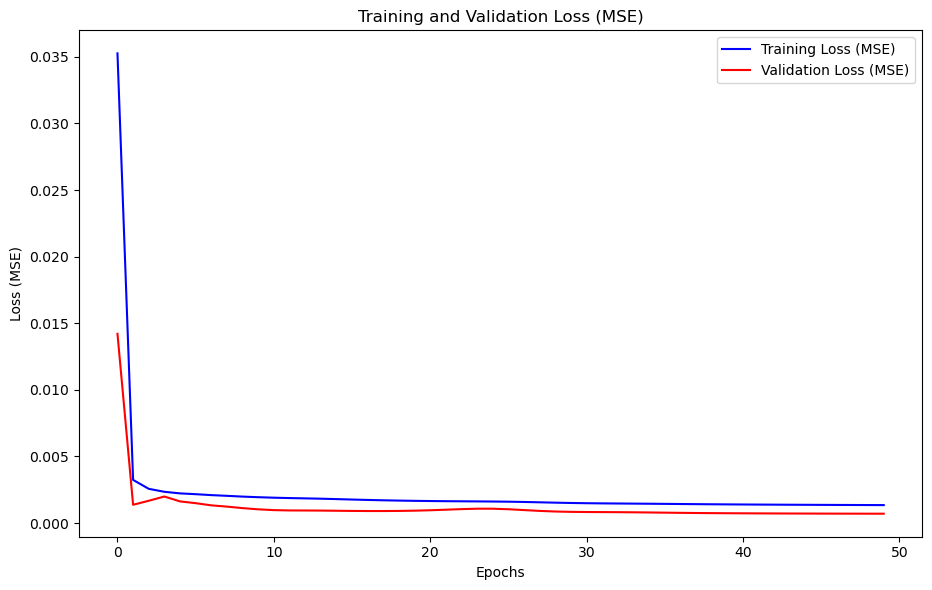

In [20]:
plot_loss(history_baseline)

In [21]:
scaler = joblib.load('/Users/aries/Downloads/StockPrediction/models/minmax_scaler.pkl')

In [22]:
train_rmse_baseline, val_rmse_baseline, val_mape_baseline = evaluate_model(baseline_model, X_train, y_train, X_val, y_val,scaler)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train RMSE: 10.898
Validation RMSE: 7.727
Validation MAPE: 0.778%


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


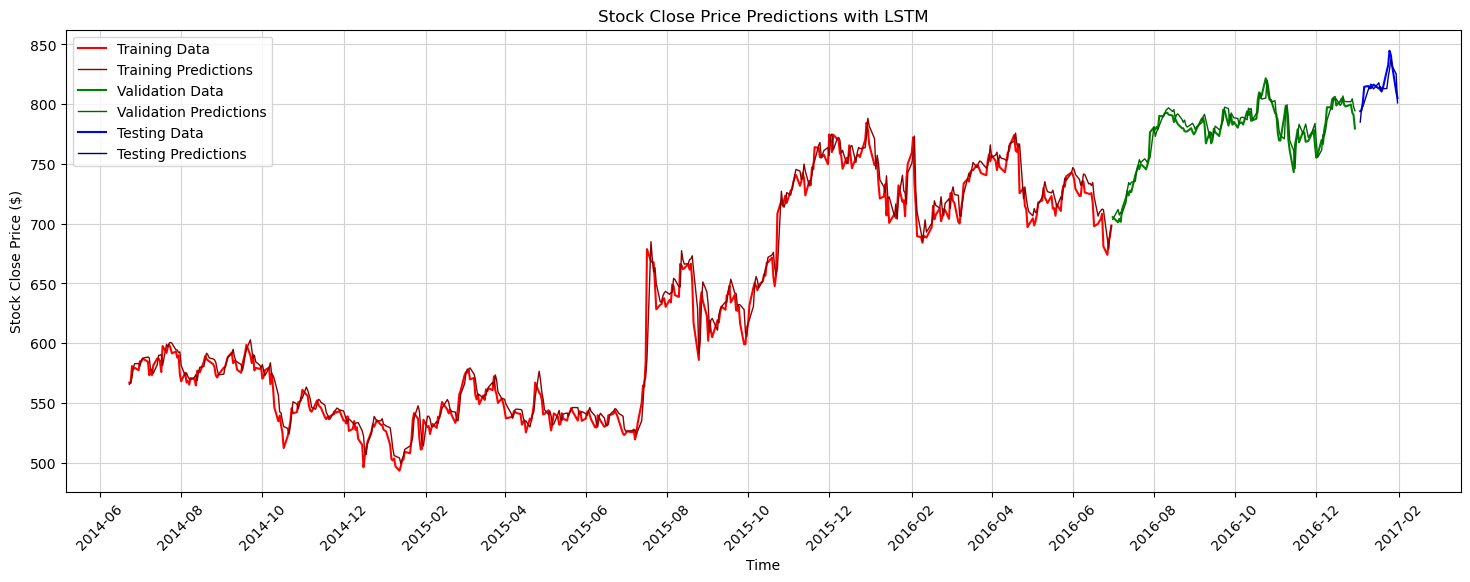

In [23]:
# Call the function to plot
plot_stock_predictions(baseline_model,
    train_dates, val_dates, test_dates,
    y_train, y_val, y_test,
    scaler
)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE: 7.666
Test MAPE: 0.698%


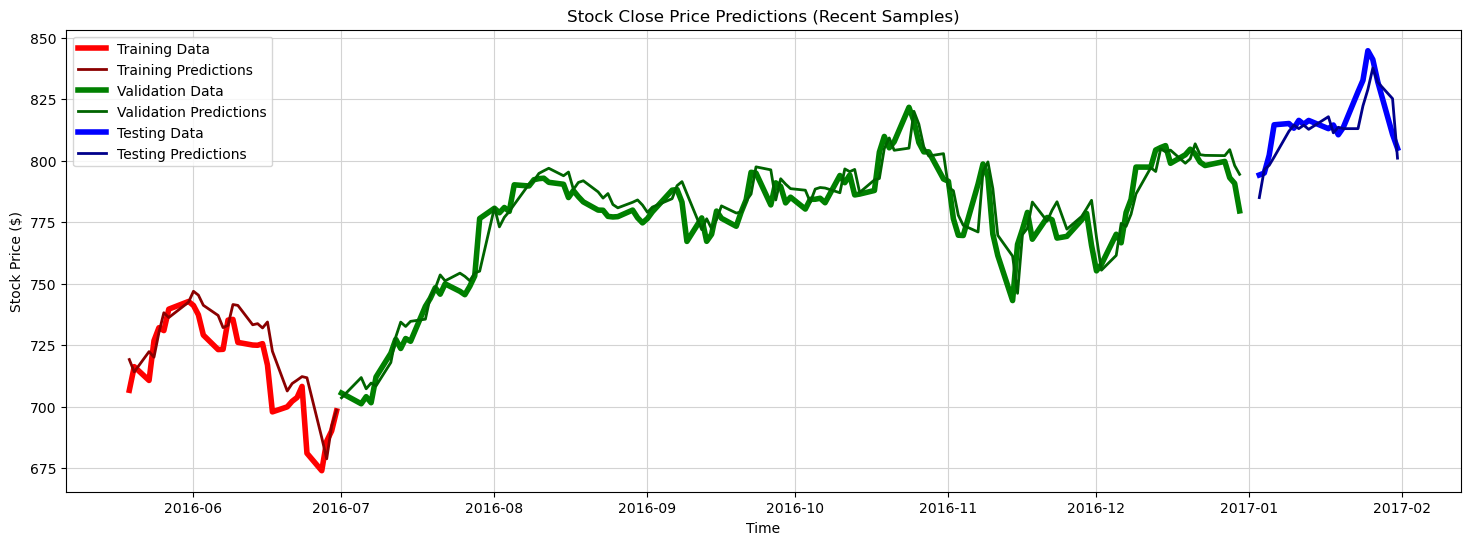

In [24]:
# Call the function to plot recent samples
plot_recent_predictions(baseline_model,
    train_dates, val_dates, test_dates,
    y_train, y_val, y_test,
    scaler, recent_samples=30
)


# Hyperparameter Tuning

In [25]:
def build_lstm_model(hp):
    model = Sequential()

    # Input layer
    input_shape = (X_train.shape[1], X_train.shape[2])  # Use the shape of your data
    model.add(Input(shape=input_shape))

    # LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 4)):  # Tune 1–4 LSTM layers
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=50, max_value=250, step=50),
            return_sequences=(i < hp.Int('num_lstm_layers', 1, 4) - 1),  # Add sequences if not the last layer
        ))
        if hp.Boolean(f'add_dropout_{i}'):  # Add dropout
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Fixed single dense layer with 1 unit
    model.add(Dense(1, activation='linear'))

    # Compile the model with optimizer choice and learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
    optimizer = Adam(learning_rate=learning_rate) if optimizer_choice == 'adam' else RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [26]:
# Define the ReduceLROnPlateau callback
def get_lr_scheduler():
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',    # Metric to monitor (e.g., 'val_loss')
        factor=0.5,            # Factor to reduce learning rate by
        patience=3,            # Number of epochs with no improvement before reducing learning rate
        min_lr=1e-6,           # Optional: Minimum learning rate to prevent it from going too low
        verbose=1              # Print the learning rate changes during training
    )
    return lr_scheduler

# Get the learning rate scheduler callback
lr_scheduler = get_lr_scheduler()

# Instantiate the tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=20,  # Number of hyperparameter configurations to try
    executions_per_trial=2,  # Number of times to evaluate each configuration
    directory='/Users/aries/Downloads/StockPrediction/models/hyperparam_tuning_2',
    project_name='lstm_tuning_v2'
)

# Define a custom function to dynamically retrieve epochs and batch size
def dynamic_tuner_search(tuner, X_train, y_train, X_val, y_val):
    for trial in range(tuner.oracle.max_trials):
        # Retrieve the current batch size and epochs from the trial
        hp = tuner.oracle.hyperparameters
        batch_size = hp.Int('batch_size', 32, 128, step=32)  # Tune batch size (16–128)
        epochs = hp.Int('epochs', 50, 200, step=50)  # Tune epochs (10–50)

        tuner.search(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[lr_scheduler],
            verbose=1
        )

Reloading Tuner from /Users/aries/Downloads/StockPrediction/models/hyperparam_tuning_2/lstm_tuning_v2/tuner0.json


In [27]:
# Perform the search
dynamic_tuner_search(tuner, X_train, y_train, X_val, y_val)

In [28]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [29]:
# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Best Hyperparameters:
num_lstm_layers: 1
lstm_units_0: 250
add_dropout_0: True
optimizer: rmsprop
learning_rate: 0.001
batch_size: 128
epochs: 150
dropout_rate_0: 0.30000000000000004
lstm_units_1: 200
add_dropout_1: True
lstm_units_2: 100
add_dropout_2: False
dropout_rate_1: 0.4
dropout_rate_2: 0.4
lstm_units_3: 150
add_dropout_3: True
dropout_rate_3: 0.4


### Tuned Model

In [30]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model using the best configuration
best_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_hps.get('epochs'),  # Use the best number of epochs
    batch_size=best_hps.get('batch_size'),  # Use the best batch size
    callbacks=[lr_scheduler],
    verbose=1 
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.1723 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.0078 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.0071 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0070 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0062 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0070 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0100
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0098 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.0065 - val_loss: 0.0023 - learning_rate: 5.000

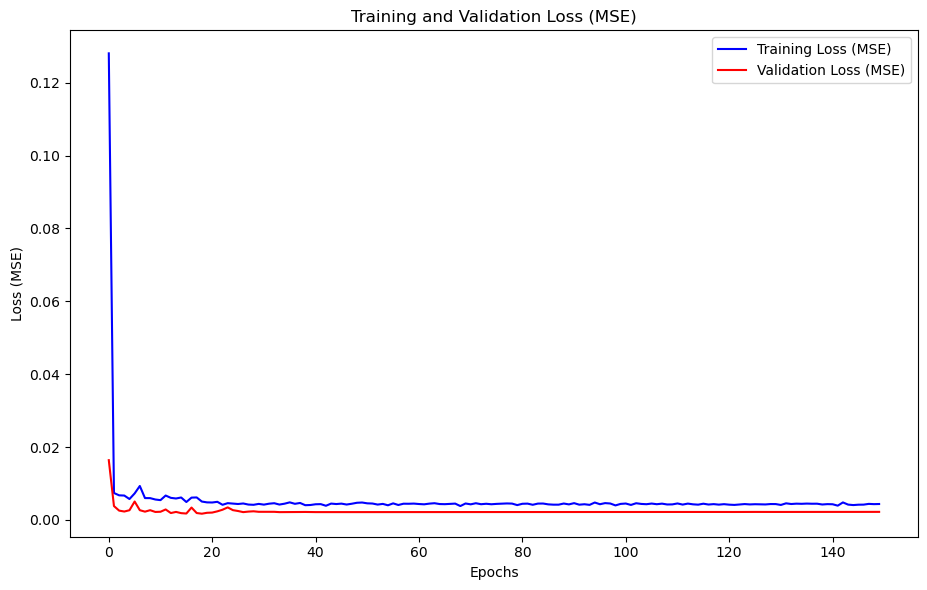

In [31]:
plot_loss(best_history)

In [32]:
train_rmse_best, val_rmse_best, val_mape_best = evaluate_model(best_model, X_train, y_train, X_val, y_val,scaler)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train RMSE: 16.637
Validation RMSE: 13.689
Validation MAPE: 1.424%


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


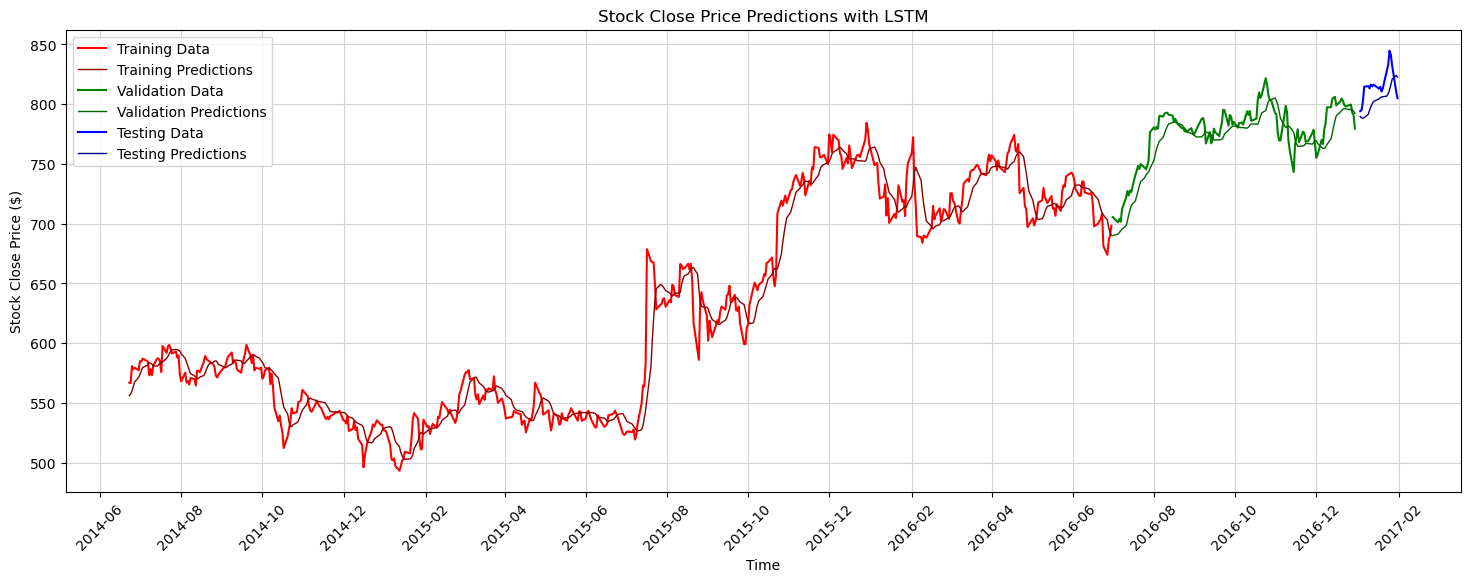

In [33]:
# Call the function to plot
plot_stock_predictions(best_model,
    train_dates, val_dates, test_dates,
    y_train, y_val, y_test,
    scaler
)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test RMSE: 17.538
Test MAPE: 1.917%


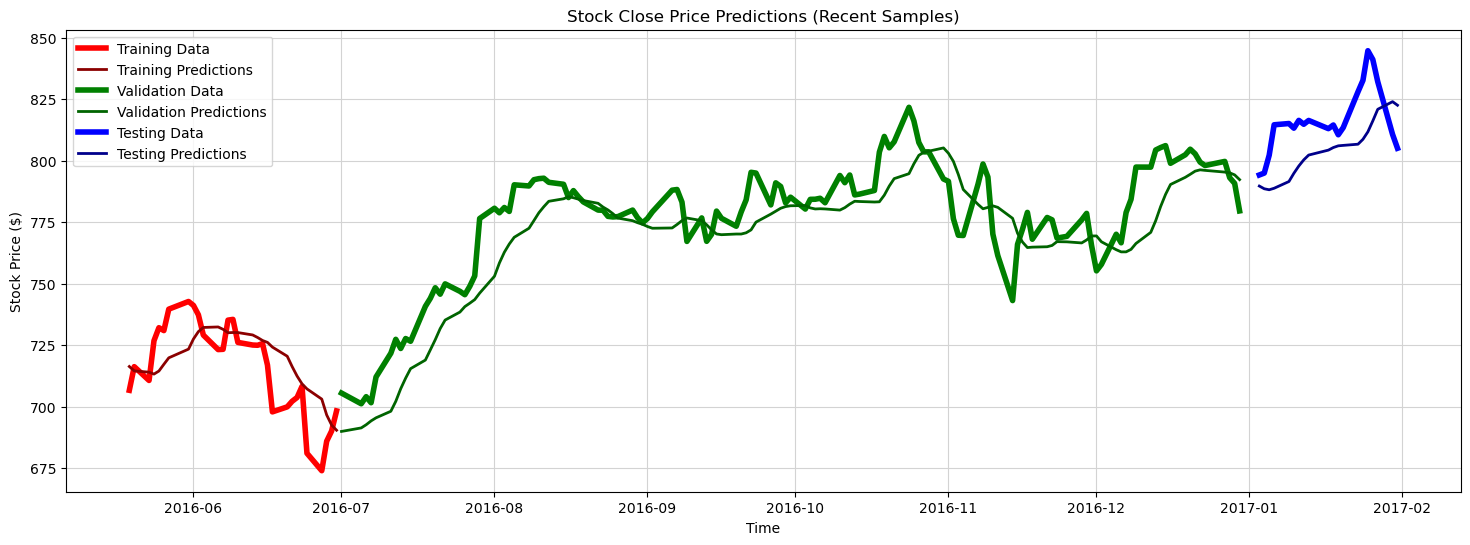

In [34]:
# Call the function to plot recent samples
plot_recent_predictions(best_model,
    train_dates, val_dates, test_dates,
    y_train, y_val, y_test,
    scaler, recent_samples=30
)
